In [1]:
num_epochs = 50


In [2]:
#Import the data for each company
import pandas as pd

#Empresa 
df = pd.read_csv('KOFUBL.csv') 
df

#Define the target 
target = "Cierre"

df = df.drop(['Fecha','% var.', 'Vol.'], axis=1)
df

,Cierre,Apertura,Máximo,Mínimo
0,165.60,160.22,165.98,160.22
1,160.22,154.38,160.67,151.84
2,154.68,155.31,156.76,154.26
3,155.86,154.67,156.43,153.49
4,155.36,152.57,156.72,152.57
...,...,...,...,...
1143,114.81,116.07,116.11,114.10
1144,115.34,116.45,116.80,115.02
1145,115.91,116.03,116.12,114.77
1146,116.45,115.60,116.62,114.77


In [3]:
#Define the features
features = list(df.columns.difference([]))
features

['Cierre', 'Apertura', 'Máximo', 'Mínimo']

In [4]:
#Define the training and test percentages
training_percentage = 0.67
size = int(len(df) * training_percentage)

df_train = df.loc[:size].copy()
df_test = df.loc[size:].copy()

In [5]:
#Normalize the data
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [6]:
#LSTM training
from utils import SequenceDataset
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

#Sets the seed for generating random numbers
torch.manual_seed(101) 

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 4])
Target shape: torch.Size([1])


In [7]:
#Define functions to train/test the model
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    accuracy = 1.0 / (avg_loss + 1e-7)

    print(f"Train loss: {avg_loss}")
    print(f"Train accuracy: {accuracy}")
    return avg_loss, accuracy


def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    accuracy = 1.0 / (avg_loss + 1e-7)
    print(f"Test loss: {avg_loss}")
    print(f"Test accuracy: {accuracy}")
    return avg_loss, accuracy

In [8]:
#Define the parameters to train the model
from utils import ShallowRegressionLSTM
from torch import nn

learning_rate = 0.0001
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

classical_loss_train = []
classical_acc_train = []
classical_loss_test = []
classical_acc_test = []
print("Untrained test\n--------")
test_loss, test_accuracy = test_model(test_loader, model, loss_function)
print()
classical_loss_test.append(test_loss)
classical_acc_test.append(test_accuracy)

for ix_epoch in range(0,num_epochs):
  print(f"Epoch {ix_epoch}\n---------")
  train_loss, train_accuracy = train_model(train_loader, model, loss_function, optimizer=optimizer)
  test_loss, test_accuracy = test_model(test_loader, model, loss_function)
  classical_loss_train.append(train_loss)
  classical_acc_train.append(train_accuracy)
  classical_loss_test.append(test_loss)
  classical_acc_test.append(test_accuracy)

Untrained test
--------
Test loss: 4.224583616200097
Test accuracy: 0.23670971323524245

Epoch 0
---------
Train loss: 0.747504917842198
Train accuracy: 1.3377836618229968
Test loss: 2.318618071032074
Test accuracy: 0.4312913667690595
Epoch 1
---------
Train loss: 0.19667299361956617
Train accuracy: 5.0845796015917974
Test loss: 0.7969458229119415
Test accuracy: 1.2547902828163349
Epoch 2
---------
Train loss: 0.042136476440224696
Train accuracy: 23.732350477467204
Test loss: 0.5305565350782866
Test accuracy: 1.8848129188930876
Epoch 3
---------
Train loss: 0.029056768169714427
Train accuracy: 34.4152712590783
Test loss: 0.48944931242244566
Test accuracy: 2.0431120655568304
Epoch 4
---------
Train loss: 0.02198386570343491
Train accuracy: 45.487698329321624
Test loss: 0.4465149928072939
Test accuracy: 2.239565954451573
Epoch 5
---------
Train loss: 0.01696723290282555
Train accuracy: 58.93678197552612
Test loss: 0.3643738250092056
Test accuracy: 2.744433482650373
Epoch 6
---------
Trai

In [9]:
#Save the cmodel
torch.save(model.state_dict(), "./cmodelKOFUBL" )

In [10]:
#Define the function to predict using the model
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output

In [11]:
#Compare the real value vs. the predicted value
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

      Cierre  Model forecast
0     165.60      163.328201
1     160.22      158.277588
2     154.68      155.279160
3     155.86      155.058929
4     155.36      154.587906
...      ...             ...
1143  114.81      114.870094
1144  115.34      115.568985
1145  115.91      115.784134
1146  116.45      115.973969
1147  115.51      115.581619

[1149 rows x 2 columns]


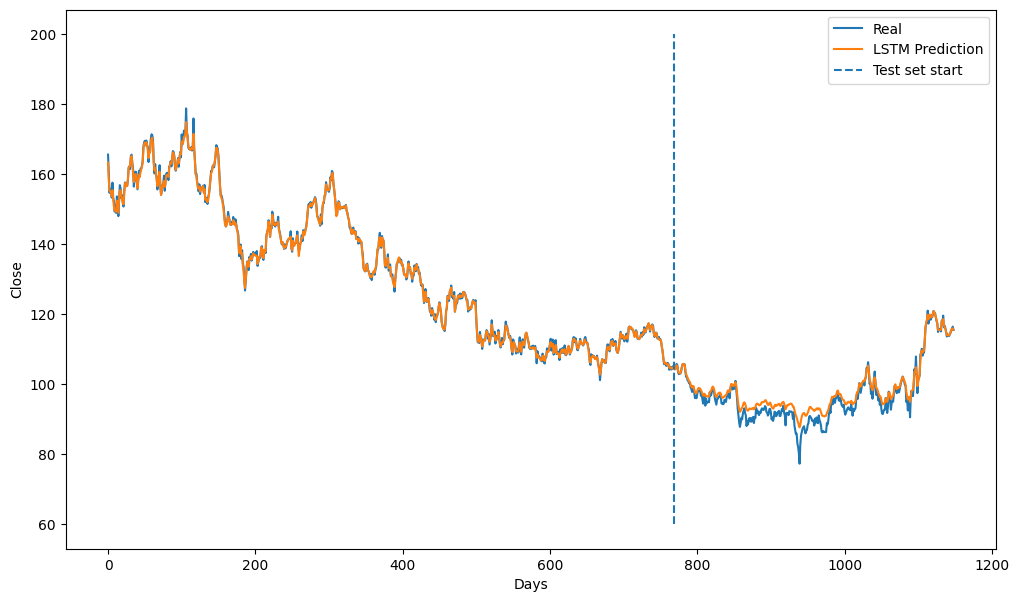

In [12]:
plt.figure(figsize=(12, 7))
plt.plot(range(0,len(df) + 1), df_out["Cierre"], label = "Real")
plt.plot(range(0,len(df) + 1), df_out["Model forecast"], label = "LSTM Prediction")
plt.ylabel('Close')
plt.xlabel('Days')
plt.vlines(size, ymin = 60, ymax = 200, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

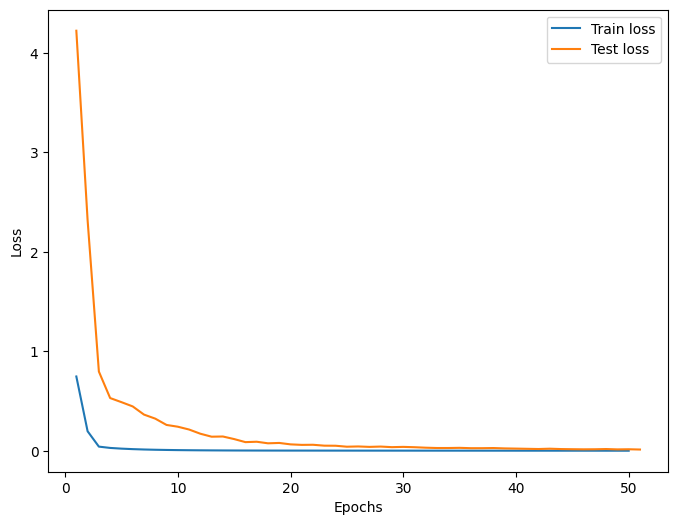

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), classical_loss_train, label = "Train loss")
plt.plot(range(1, num_epochs + 2), classical_loss_test, label="Test loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [14]:
#Quantum prediction
from utils import QShallowRegressionLSTM

learning_rate = 0.05
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits = 4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 4)


In [15]:
#Train the quantum model
import time

quantum_loss_train = []
quantum_acc_train = []
quantum_loss_test = []
quantum_acc_test = []
print("Untrained test\n--------")
start = time.time()
test_loss, test_accuracy = test_model(test_loader, Qmodel, loss_function)
end = time.time()
print("Execution time", end - start)
quantum_loss_test.append(test_loss)

for ix_epoch in range(0, num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss, train_accuracy = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss, test_accuracy = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_acc_train.append(train_accuracy)
    quantum_loss_test.append(test_loss)
    quantum_acc_test.append(test_accuracy)

Untrained test
--------
Test loss: 3.4317627942341926
Test accuracy: 0.29139542294140713
Execution time 16.534438371658325
Epoch 0
---------
Train loss: 0.058358471895613946
Train accuracy: 17.13544330366242
Test loss: 0.44755749966934866
Test accuracy: 2.234349278704664
Execution time 78.45772552490234
Epoch 1
---------
Train loss: 0.006250771132385588
Train accuracy: 159.97770211883397
Test loss: 0.2926388192002169
Test accuracy: 3.4171804718695764
Execution time 78.31173372268677
Epoch 2
---------
Train loss: 0.00376085889744787
Train accuracy: 265.8896380597472
Test loss: 0.23072376825381025
Test accuracy: 4.334185308040776
Execution time 78.25733017921448
Epoch 3
---------
Train loss: 0.0026771691696267854
Train accuracy: 373.51492757801464
Test loss: 0.2684604597068936
Test accuracy: 3.7249419471217835
Execution time 78.08026218414307
Epoch 4
---------
Train loss: 0.0020478607688127
Train accuracy: 488.2906036231092
Test loss: 0.21079256127895682
Test accuracy: 4.7439981730513345

In [16]:
#Save the qmodel
torch.save(Qmodel.state_dict(), "./qmodelKOFUBL" )

In [17]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_loader, Qmodel).numpy()

df_out_Q = pd.concat((df_train, df_test))[[target, ystar_col_Q]]

for c in df_out_Q.columns:
    df_out_Q[c] = df_out_Q[c] * target_stdev + target_mean

print(df_out_Q)

      Cierre  Model forecast
0     165.60      165.742706
1     160.22      160.029770
2     154.68      154.371918
3     155.86      156.067963
4     155.36      155.586014
...      ...             ...
1143  114.81      114.703590
1144  115.34      115.282860
1145  115.91      115.757957
1146  116.45      116.361023
1147  115.51      115.454277

[1149 rows x 2 columns]


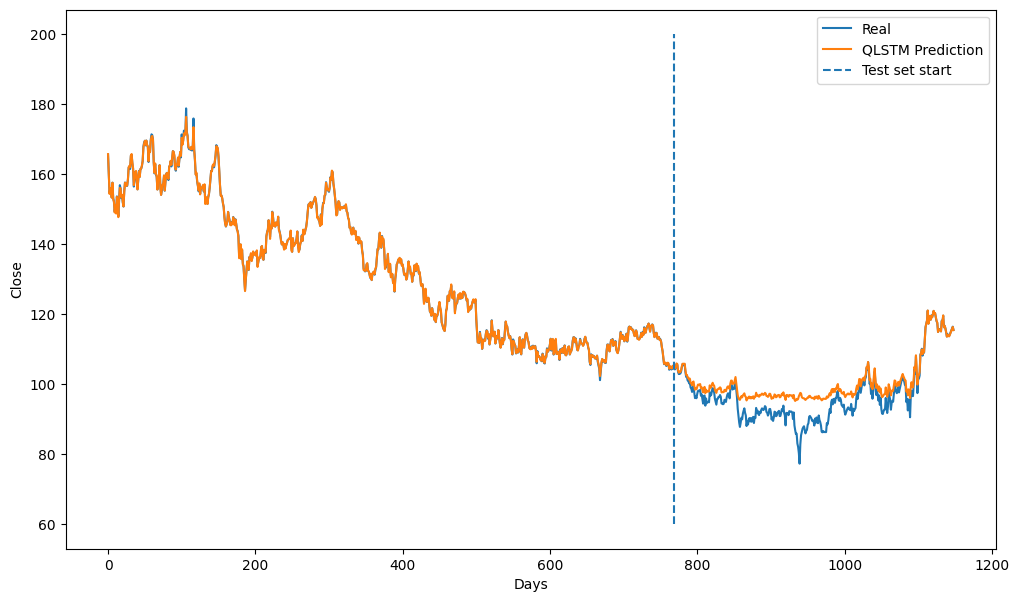

In [18]:
plt.figure(figsize=(12, 7))
plt.plot(range(0,len(df) + 1), df_out_Q["Cierre"], label = "Real")
plt.plot(range(0,len(df) + 1), df_out_Q["Model forecast"], label = "QLSTM Prediction")
plt.ylabel('Close')
plt.xlabel('Days')
plt.vlines(size, ymin = 60, ymax = 200, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

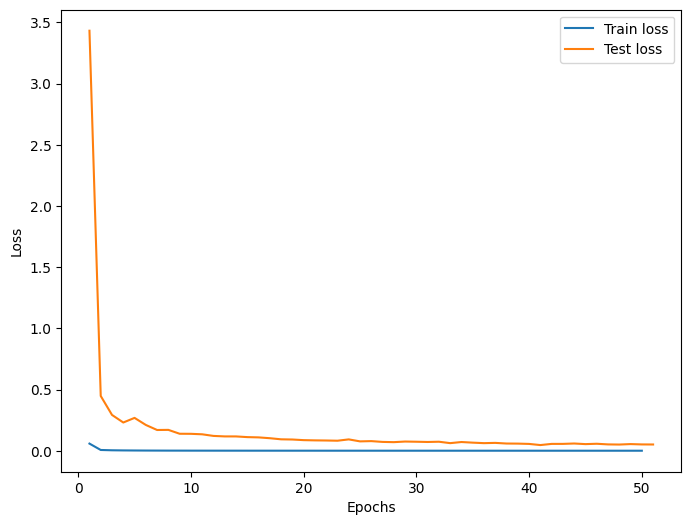

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), quantum_loss_train, label = "Train loss")
plt.plot(range(1, num_epochs + 2), quantum_loss_test, label="Test loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

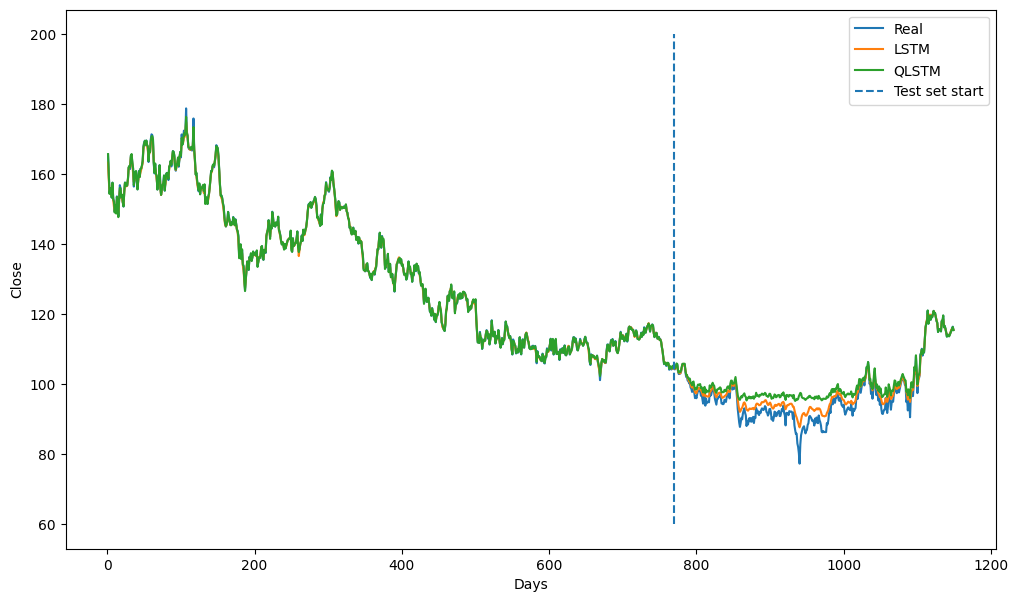

In [23]:
##Comparison between classical and quantum
plt.figure(figsize=(12, 7))
plt.plot(range(1, len(df) + 2), df_out_Q["Cierre"], label = "Real")
plt.plot(range(1, len(df) + 2), df_out["Model forecast"], label = "LSTM")
plt.plot(range(1, len(df) + 2), df_out_Q["Model forecast"], label = "QLSTM")
plt.ylabel('Close')
plt.xlabel('Days')
plt.vlines(size, ymin = 60, ymax = 200, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()